# Prelims

In [13]:
!nvidia-smi

Fri Oct 15 13:17:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |   1225MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-y5pur2w1
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-y5pur2w1
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=345ffc8089333d2fea0f9726b0c0a62619b14ed35750be2836a5eace16111df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-rlpoia1z/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


In [ ]:
# !git clone https://github.com/facebookresearch/detectron2.git
# !pip install ./detectron2
# !pip install --upgrade pyyaml

Copy sample files

In [ ]:
!mkdir -p /content/dataset/sanitary_fixtures/images

In [ ]:
!cp -r /content/drive/MyDrive/EVA/cap/new/* /content/dataset/sanitary_fixtures/

In [ ]:
# !cp /content/drive/MyDrive/EVA/cap/new/images/sanitary_001.jpg /content/dataset/sanitary_fixtures/images
# !cp /content/drive/MyDrive/EVA/cap/new/coco.json /content/dataset/sanitary_fixtures/
# !cp /content/drive/MyDrive/EVA/cap/new/images/image_000.jpg /content/dataset/sanitary_fixtures/images

# Panoptic segmentation using DETR

In this notebook we demonstrate how to explore the panoptic segmentation capabilities of DETR. The prediction occurs in several steps: 

1.   The model predicts a box and a binary mask for each object queries
2.   We filter the predictions for which the confidence is < 85%
3.   Finally, the remaining masks are merged together using a pixel-wise argmax

For simplicity, we rely on DETR's postprocessor to execute 2 and 3. We encourage to take a look at the corresponding code to get a better understanding of the process.

Finally, we visualize the final prediction using Detectron2.

The panoptic API is required for panoptic inference

In [4]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [5]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy as np
torch.set_grad_enabled(False);

In [6]:
# All coco categories, together with their nice-looking visualization colors
# It's from https://github.com/cocodataset/panopticapi/blob/master/panoptic_coco_categories.json
COCO_CATEGORIES = [
    {"color": [220, 20, 60], "isthing": 1, "id": 1, "name": "person"},
    {"color": [119, 11, 32], "isthing": 1, "id": 2, "name": "bicycle"},
    {"color": [0, 0, 142], "isthing": 1, "id": 3, "name": "car"},
    {"color": [0, 0, 230], "isthing": 1, "id": 4, "name": "motorcycle"},
    {"color": [106, 0, 228], "isthing": 1, "id": 5, "name": "airplane"},
    {"color": [0, 60, 100], "isthing": 1, "id": 6, "name": "bus"},
    {"color": [0, 80, 100], "isthing": 1, "id": 7, "name": "train"},
    {"color": [0, 0, 70], "isthing": 1, "id": 8, "name": "truck"},
    {"color": [0, 0, 192], "isthing": 1, "id": 9, "name": "boat"},
    {"color": [250, 170, 30], "isthing": 1, "id": 10, "name": "traffic light"},
    {"color": [100, 170, 30], "isthing": 1, "id": 11, "name": "fire hydrant"},
    {"color": [220, 220, 0], "isthing": 1, "id": 13, "name": "stop sign"},
    {"color": [175, 116, 175], "isthing": 1, "id": 14, "name": "parking meter"},
    {"color": [250, 0, 30], "isthing": 1, "id": 15, "name": "bench"},
    {"color": [165, 42, 42], "isthing": 1, "id": 16, "name": "bird"},
    {"color": [255, 77, 255], "isthing": 1, "id": 17, "name": "cat"},
    {"color": [0, 226, 252], "isthing": 1, "id": 18, "name": "dog"},
    {"color": [182, 182, 255], "isthing": 1, "id": 19, "name": "horse"},
    {"color": [0, 82, 0], "isthing": 1, "id": 20, "name": "sheep"},
    {"color": [120, 166, 157], "isthing": 1, "id": 21, "name": "cow"},
    {"color": [110, 76, 0], "isthing": 1, "id": 22, "name": "elephant"},
    {"color": [174, 57, 255], "isthing": 1, "id": 23, "name": "bear"},
    {"color": [199, 100, 0], "isthing": 1, "id": 24, "name": "zebra"},
    {"color": [72, 0, 118], "isthing": 1, "id": 25, "name": "giraffe"},
    {"color": [255, 179, 240], "isthing": 1, "id": 27, "name": "backpack"},
    {"color": [0, 125, 92], "isthing": 1, "id": 28, "name": "umbrella"},
    {"color": [209, 0, 151], "isthing": 1, "id": 31, "name": "handbag"},
    {"color": [188, 208, 182], "isthing": 1, "id": 32, "name": "tie"},
    {"color": [0, 220, 176], "isthing": 1, "id": 33, "name": "suitcase"},
    {"color": [255, 99, 164], "isthing": 1, "id": 34, "name": "frisbee"},
    {"color": [92, 0, 73], "isthing": 1, "id": 35, "name": "skis"},
    {"color": [133, 129, 255], "isthing": 1, "id": 36, "name": "snowboard"},
    {"color": [78, 180, 255], "isthing": 1, "id": 37, "name": "sports ball"},
    {"color": [0, 228, 0], "isthing": 1, "id": 38, "name": "kite"},
    {"color": [174, 255, 243], "isthing": 1, "id": 39, "name": "baseball bat"},
    {"color": [45, 89, 255], "isthing": 1, "id": 40, "name": "baseball glove"},
    {"color": [134, 134, 103], "isthing": 1, "id": 41, "name": "skateboard"},
    {"color": [145, 148, 174], "isthing": 1, "id": 42, "name": "surfboard"},
    {"color": [255, 208, 186], "isthing": 1, "id": 43, "name": "tennis racket"},
    {"color": [197, 226, 255], "isthing": 1, "id": 44, "name": "bottle"},
    {"color": [171, 134, 1], "isthing": 1, "id": 46, "name": "wine glass"},
    {"color": [109, 63, 54], "isthing": 1, "id": 47, "name": "cup"},
    {"color": [207, 138, 255], "isthing": 1, "id": 48, "name": "fork"},
    {"color": [151, 0, 95], "isthing": 1, "id": 49, "name": "knife"},
    {"color": [9, 80, 61], "isthing": 1, "id": 50, "name": "spoon"},
    {"color": [84, 105, 51], "isthing": 1, "id": 51, "name": "bowl"},
    {"color": [74, 65, 105], "isthing": 1, "id": 52, "name": "banana"},
    {"color": [166, 196, 102], "isthing": 1, "id": 53, "name": "apple"},
    {"color": [208, 195, 210], "isthing": 1, "id": 54, "name": "sandwich"},
    {"color": [255, 109, 65], "isthing": 1, "id": 55, "name": "orange"},
    {"color": [0, 143, 149], "isthing": 1, "id": 56, "name": "broccoli"},
    {"color": [179, 0, 194], "isthing": 1, "id": 57, "name": "carrot"},
    {"color": [209, 99, 106], "isthing": 1, "id": 58, "name": "hot dog"},
    {"color": [5, 121, 0], "isthing": 1, "id": 59, "name": "pizza"},
    {"color": [227, 255, 205], "isthing": 1, "id": 60, "name": "donut"},
    {"color": [147, 186, 208], "isthing": 1, "id": 61, "name": "cake"},
    {"color": [153, 69, 1], "isthing": 1, "id": 62, "name": "chair"},
    {"color": [3, 95, 161], "isthing": 1, "id": 63, "name": "couch"},
    {"color": [163, 255, 0], "isthing": 1, "id": 64, "name": "potted plant"},
    {"color": [119, 0, 170], "isthing": 1, "id": 65, "name": "bed"},
    {"color": [0, 182, 199], "isthing": 1, "id": 67, "name": "dining table"},
    {"color": [0, 165, 120], "isthing": 1, "id": 70, "name": "toilet"},
    {"color": [183, 130, 88], "isthing": 1, "id": 72, "name": "tv"},
    {"color": [95, 32, 0], "isthing": 1, "id": 73, "name": "laptop"},
    {"color": [130, 114, 135], "isthing": 1, "id": 74, "name": "mouse"},
    {"color": [110, 129, 133], "isthing": 1, "id": 75, "name": "remote"},
    {"color": [166, 74, 118], "isthing": 1, "id": 76, "name": "keyboard"},
    {"color": [219, 142, 185], "isthing": 1, "id": 77, "name": "cell phone"},
    {"color": [79, 210, 114], "isthing": 1, "id": 78, "name": "microwave"},
    {"color": [178, 90, 62], "isthing": 1, "id": 79, "name": "oven"},
    {"color": [65, 70, 15], "isthing": 1, "id": 80, "name": "toaster"},
    {"color": [127, 167, 115], "isthing": 1, "id": 81, "name": "sink"},
    {"color": [59, 105, 106], "isthing": 1, "id": 82, "name": "refrigerator"},
    {"color": [142, 108, 45], "isthing": 1, "id": 84, "name": "book"},
    {"color": [196, 172, 0], "isthing": 1, "id": 85, "name": "clock"},
    {"color": [95, 54, 80], "isthing": 1, "id": 86, "name": "vase"},
    {"color": [128, 76, 255], "isthing": 1, "id": 87, "name": "scissors"},
    {"color": [201, 57, 1], "isthing": 1, "id": 88, "name": "teddy bear"},
    {"color": [246, 0, 122], "isthing": 1, "id": 89, "name": "hair drier"},
    {"color": [191, 162, 208], "isthing": 1, "id": 90, "name": "toothbrush"},
    {"color": [255, 255, 128], "isthing": 0, "id": 92, "name": "banner"},
    {"color": [147, 211, 203], "isthing": 0, "id": 93, "name": "blanket"},
    {"color": [150, 100, 100], "isthing": 0, "id": 95, "name": "bridge"},
    {"color": [168, 171, 172], "isthing": 0, "id": 100, "name": "cardboard"},
    {"color": [146, 112, 198], "isthing": 0, "id": 107, "name": "counter"},
    {"color": [210, 170, 100], "isthing": 0, "id": 109, "name": "curtain"},
    {"color": [92, 136, 89], "isthing": 0, "id": 112, "name": "door-stuff"},
    {"color": [218, 88, 184], "isthing": 0, "id": 118, "name": "floor-wood"},
    {"color": [241, 129, 0], "isthing": 0, "id": 119, "name": "flower"},
    {"color": [217, 17, 255], "isthing": 0, "id": 122, "name": "fruit"},
    {"color": [124, 74, 181], "isthing": 0, "id": 125, "name": "gravel"},
    {"color": [70, 70, 70], "isthing": 0, "id": 128, "name": "house"},
    {"color": [255, 228, 255], "isthing": 0, "id": 130, "name": "light"},
    {"color": [154, 208, 0], "isthing": 0, "id": 133, "name": "mirror-stuff"},
    {"color": [193, 0, 92], "isthing": 0, "id": 138, "name": "net"},
    {"color": [76, 91, 113], "isthing": 0, "id": 141, "name": "pillow"},
    {"color": [255, 180, 195], "isthing": 0, "id": 144, "name": "platform"},
    {"color": [106, 154, 176], "isthing": 0, "id": 145, "name": "playingfield"},
    {"color": [230, 150, 140], "isthing": 0, "id": 147, "name": "railroad"},
    {"color": [60, 143, 255], "isthing": 0, "id": 148, "name": "river"},
    {"color": [128, 64, 128], "isthing": 0, "id": 149, "name": "road"},
    {"color": [92, 82, 55], "isthing": 0, "id": 151, "name": "roof"},
    {"color": [254, 212, 124], "isthing": 0, "id": 154, "name": "sand"},
    {"color": [73, 77, 174], "isthing": 0, "id": 155, "name": "sea"},
    {"color": [255, 160, 98], "isthing": 0, "id": 156, "name": "shelf"},
    {"color": [255, 255, 255], "isthing": 0, "id": 159, "name": "snow"},
    {"color": [104, 84, 109], "isthing": 0, "id": 161, "name": "stairs"},
    {"color": [169, 164, 131], "isthing": 0, "id": 166, "name": "tent"},
    {"color": [225, 199, 255], "isthing": 0, "id": 168, "name": "towel"},
    {"color": [137, 54, 74], "isthing": 0, "id": 171, "name": "wall-brick"},
    {"color": [135, 158, 223], "isthing": 0, "id": 175, "name": "wall-stone"},
    {"color": [7, 246, 231], "isthing": 0, "id": 176, "name": "wall-tile"},
    {"color": [107, 255, 200], "isthing": 0, "id": 177, "name": "wall-wood"},
    {"color": [58, 41, 149], "isthing": 0, "id": 178, "name": "water-other"},
    {"color": [183, 121, 142], "isthing": 0, "id": 180, "name": "window-blind"},
    {"color": [255, 73, 97], "isthing": 0, "id": 181, "name": "window-other"},
    {"color": [107, 142, 35], "isthing": 0, "id": 184, "name": "tree-merged"},
    {"color": [190, 153, 153], "isthing": 0, "id": 185, "name": "fence-merged"},
    {"color": [146, 139, 141], "isthing": 0, "id": 186, "name": "ceiling-merged"},
    {"color": [70, 130, 180], "isthing": 0, "id": 187, "name": "sky-other-merged"},
    {"color": [134, 199, 156], "isthing": 0, "id": 188, "name": "cabinet-merged"},
    {"color": [209, 226, 140], "isthing": 0, "id": 189, "name": "table-merged"},
    {"color": [96, 36, 108], "isthing": 0, "id": 190, "name": "floor-other-merged"},
    {"color": [96, 96, 96], "isthing": 0, "id": 191, "name": "pavement-merged"},
    {"color": [64, 170, 64], "isthing": 0, "id": 192, "name": "mountain-merged"},
    {"color": [152, 251, 152], "isthing": 0, "id": 193, "name": "grass-merged"},
    {"color": [208, 229, 228], "isthing": 0, "id": 194, "name": "dirt-merged"},
    {"color": [206, 186, 171], "isthing": 0, "id": 195, "name": "paper-merged"},
    {"color": [152, 161, 64], "isthing": 0, "id": 196, "name": "food-other-merged"},
    {"color": [116, 112, 0], "isthing": 0, "id": 197, "name": "building-other-merged"},
    {"color": [0, 114, 143], "isthing": 0, "id": 198, "name": "rock-merged"},
    {"color": [102, 102, 156], "isthing": 0, "id": 199, "name": "wall-other-merged"},
    {"color": [250, 141, 255], "isthing": 0, "id": 200, "name": "rug-merged"},
]

In [8]:
# Get a list of all categories

COCO_NAMES = ["N/A"] * 201
for c in COCO_CATEGORIES:
    COCO_NAMES[c["id"]] = c["name"]

In [9]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [10]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b   

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{COCO_NAMES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()    
           

## Using a model from hub

We load a pre-trained model directly from torch hub. Note that we also request the post-processor

In [11]:
def get_device() -> tuple:
    """Get Device type

    Returns:
        tuple: Device type
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    return (use_cuda, device)

use_cuda, device = get_device()
use_cuda, device

(True, device(type='cuda'))

In [12]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model = model.to(device)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth


  0%|          | 0.00/237M [00:00<?, ?B/s]

Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

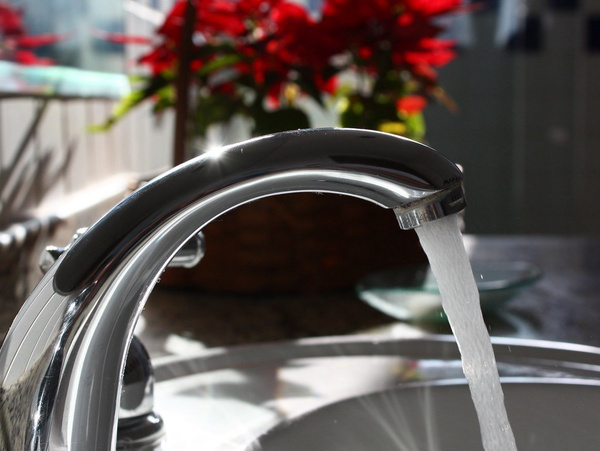

In [14]:
# url = 'https://p1.pxfuel.com/preview/381/879/820/concrete-mixer-old-oxide-rusty-scrap-rust.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# im = Image.open('/content/dataset/images/sanitary_001.jpg')
im = Image.open('/content/drive/MyDrive/EVA6/Capstone/dataset/sanitary_fixtures/images/image_000.jpg')
im 

In [15]:
w,h = im.size
w,h

(600, 451)

Finally, we run the prediction

In [16]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0).to(device)
out = model(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


This returns a mask for each query, let us visualize the high confidence ones

In [17]:
out.keys()

dict_keys(['pred_logits', 'pred_boxes', 'pred_masks'])

In [18]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

In [19]:
# convert boxes from [0; 1] to image scales
boxes = out['pred_boxes'][keep]
bboxes_scaled = rescale_bboxes(boxes, im.size)
probas = out['pred_logits'].softmax(-1)[0, :, :-1]

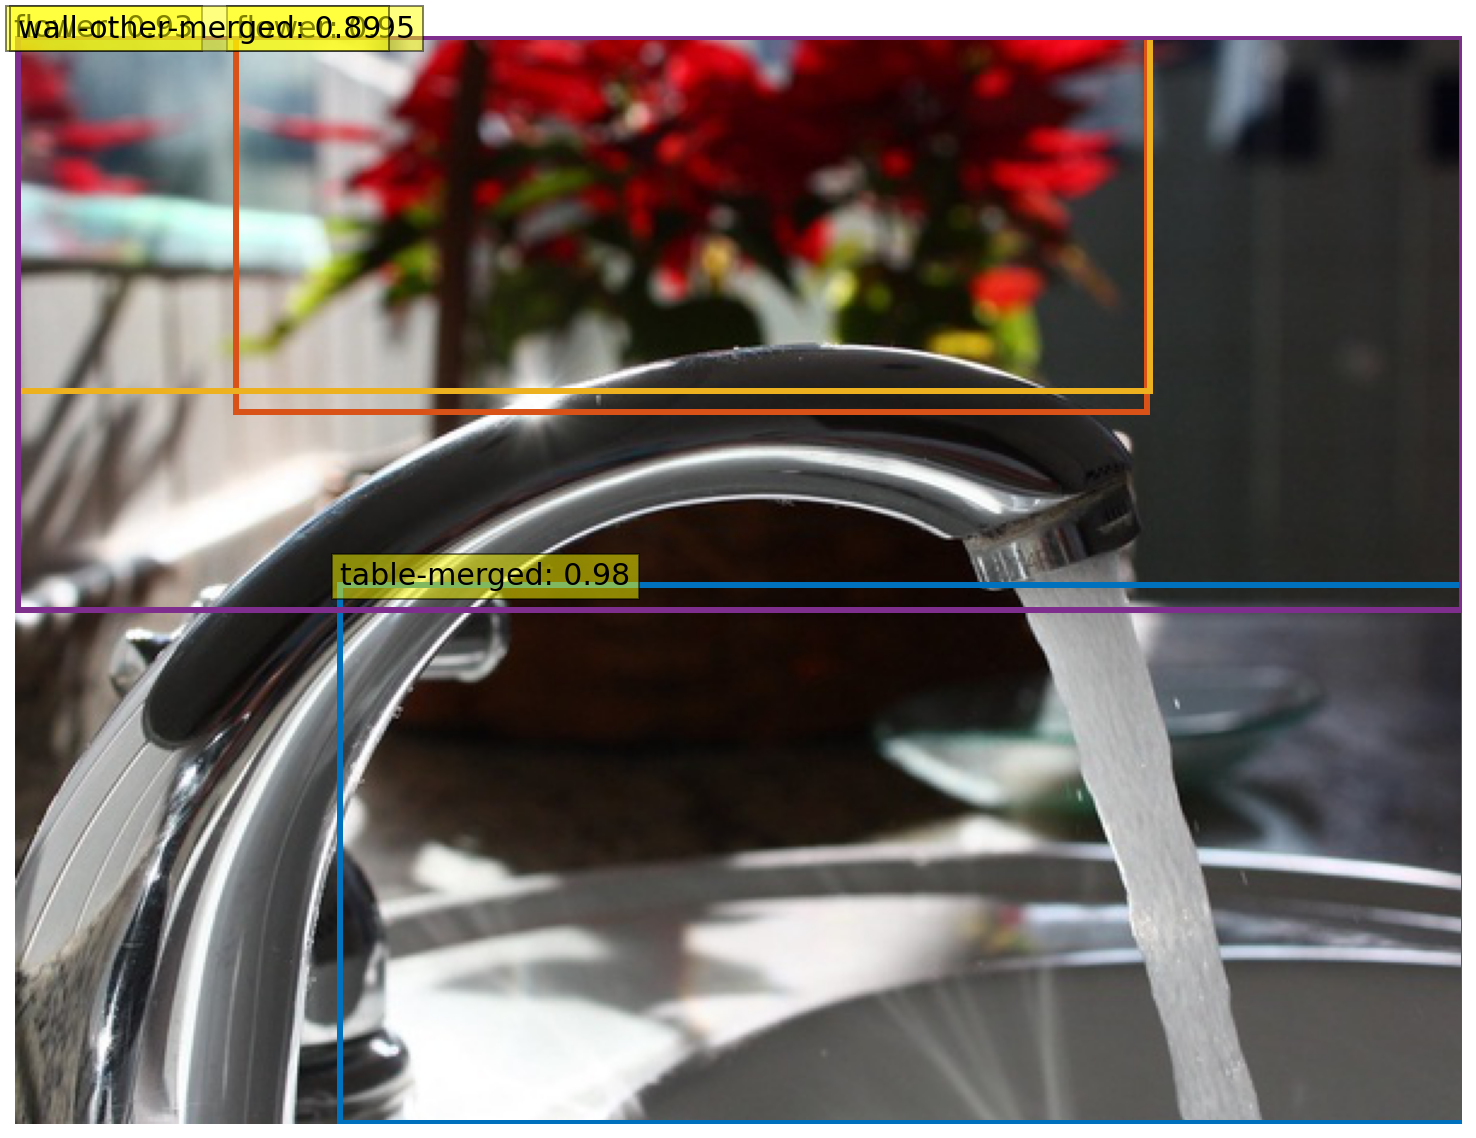

In [20]:
plot_results(im, probas[keep[0]], bboxes_scaled)

In [ ]:
# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Now that we have the individual masks, we can merge the predictions into a unified panoptic segmentation. We use DETR's postprocessor for that.


In [21]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [22]:
result

{'png_string': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04(\x00\x00\x03 \x08\x02\x00\x00\x00n\xfe\xc4H\x00\x00)\x8bIDATx\x9c\xed\xdd\xebr\xea:\xb6\x06P\xa0\xf2\xfe\x8fL\xfa\x07\xbbY\x04l#\xdb\xbaLIcT\xd79IV61\xc6\x92\xe6gY\xf6\xf5v\x01\xf2\xfb\xbd\\.\x97\xcb\xf5\xef\xb7\x00P\xc8\xf5\xfb\xaf@cr\x07\x00\x00P\x9c\xe0\x01E\\\xff\x9e|r"\n\x00\x98\x9c\xe0\x01\x95\xbc\xe5\x90\xab4\x02@&\x06\x14\xba x@mfB\x00\x80\t\xfd\xb4\xde\x00\x98\x88\x98\x01\x00L\xcb\x8c\x074&\x8d\x00p\x86q\x84^\xfc\x9b\xf1X\xbb\xdd\xa7\xa3\x19J\xbb\xba\xdf.\x00\x87\xa8\xd3\xe8\xc85\xf1xuXCi\xb2\x07\x00\xbb(\xcf\xe8K\xea\xa5VJ"\x00\x808\xa4\x0e\xba\xb3c\x8d\x87\xec\x01\x00\x00\x1c\xb3oq\xb9\xec\x01\x85h\\\x00\xa43\xddA\x8fv\xdf\xd5Jy\x04\xd9iV\x00\xc0\xf0\x8e\xdcNW\x91\x04\x19iP\x00\xc0\x0cR\xefj\xb5\xfa\xdf_.\x97\xa5\xca\xc9\x0c \xa4\x90:\x00\xd8K\x95E\xa7\xce\x06\x8f/\xaf^\xf2\xc5\xa1k"\x07\x00\xc7\xa8\xaf\xe8\xd4\xcf\xf7_9\xe1QZi\x1e\xf0J\xe4\x00\x00&td\x8d\xc7^\xbf*-\xf8?m\x01\x00\x98S\x8d\xe0\xf1\xa0\xde\x02\xa

We can now do a simple visualization of the result

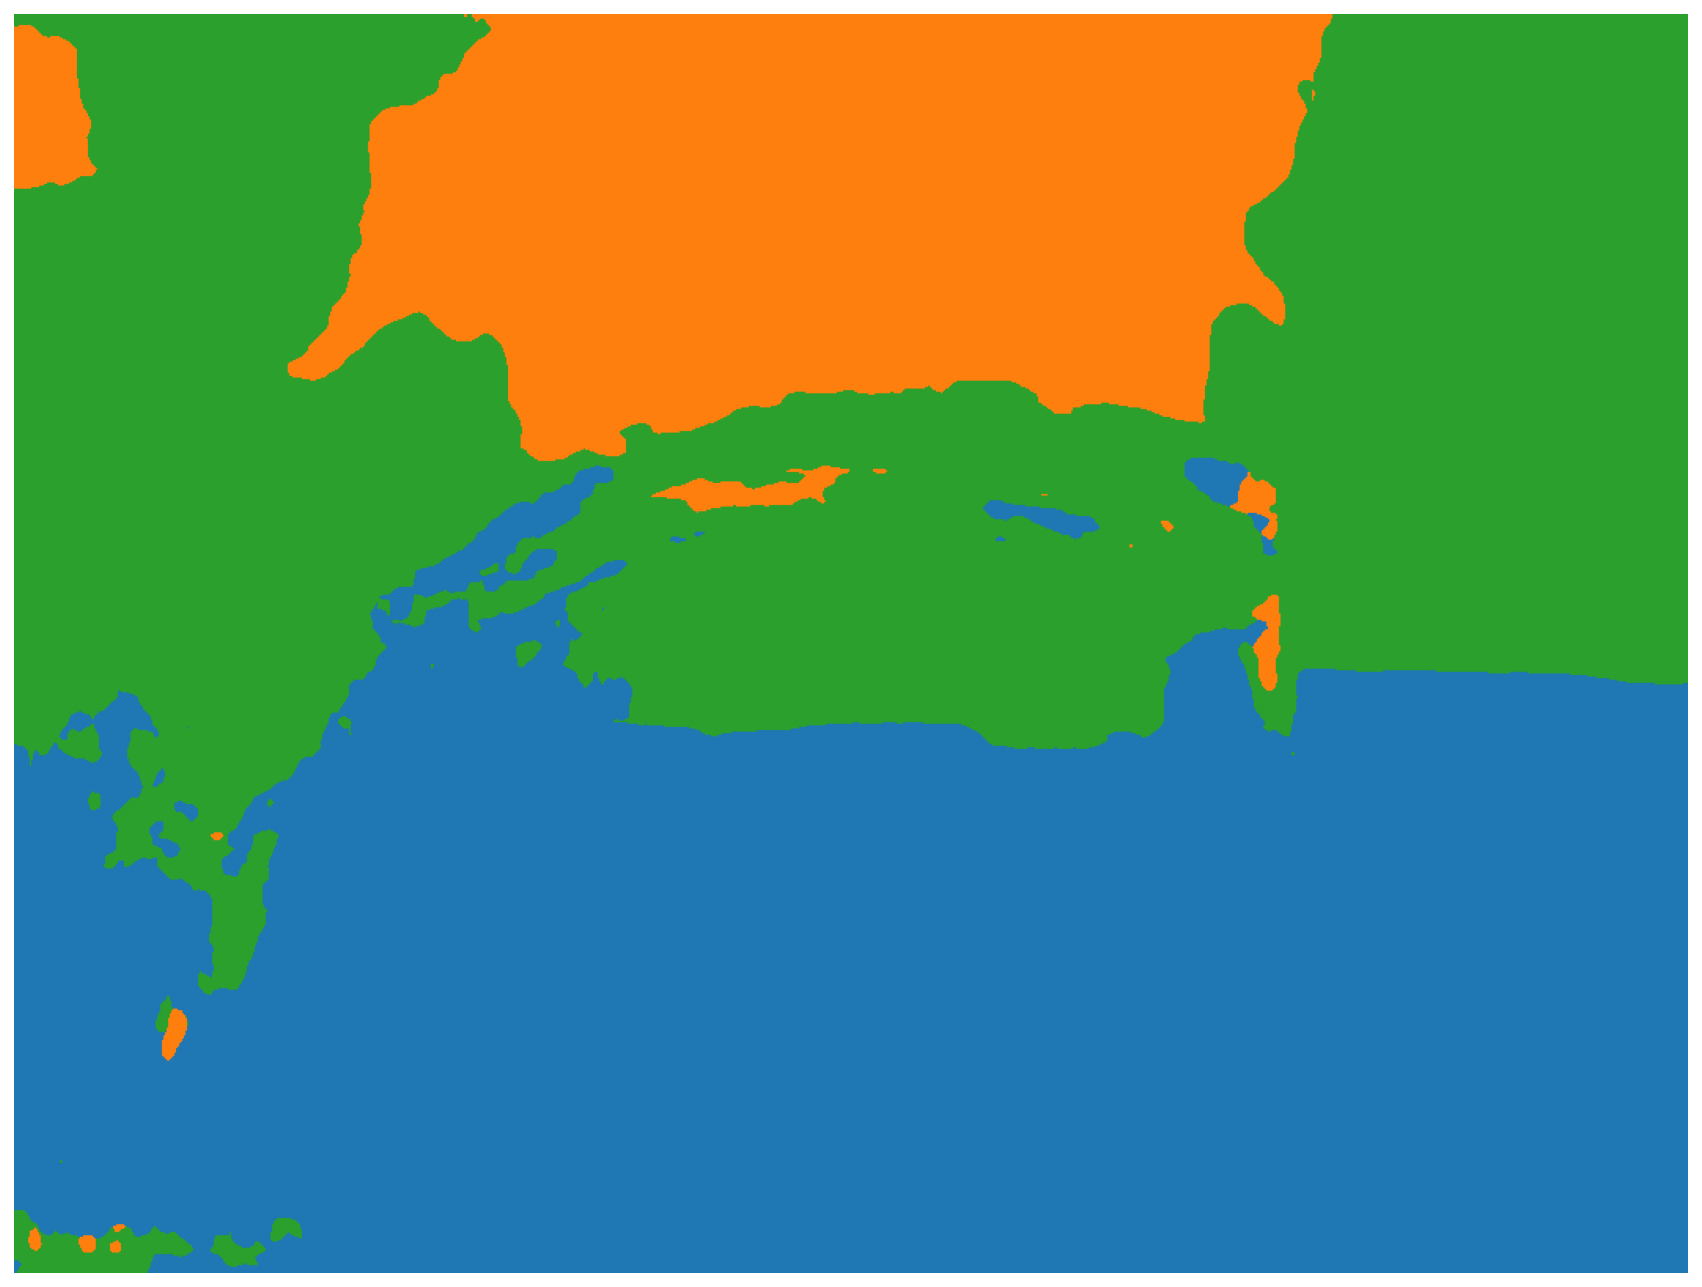

In [23]:
import itertools
import seaborn as sns

palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = np.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

In [24]:
# Convert to binary segment
binary_masks = np.zeros((panoptic_seg_id.max() + 1, panoptic_seg_id.shape[0], panoptic_seg_id.shape[1]),dtype=np.uint8)
binary_masks.shape

(3, 800, 1064)

## orginal mask from cvat

In [25]:
ROOT_DIR = "./"

processing_file = ""
processing_data = []

image_id = 1
annotation_id = 1
segment_id = 1

INFO = {
    "description": "Example Image",
    "url": "",
    "version": "",
    "year": 2021,
    "contributor": "",
    "date_created": "",
}

LICENSES = [
    {
        "id": 1,
        "name": "Attribution-NonCommercial-ShareAlike License",
        "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
    }
]


coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": COCO_CATEGORIES,
    "images": [],
    "annotations": [],
}


In [ ]:
import json
from pathlib import Path

img_folder = '/content/dataset/sanitary_fixtures/images' 
# ann_folder = '/content/drive/MyDrive/DETR/COCO data/annotations/coco_panoptic/panoptic_val2017'
ann_file='/content/dataset/sanitary_fixtures/coco.json'

In [ ]:
with open(ann_file, 'r') as f:
  coco_json = json.load(f)

In [ ]:
# sort 'images' field so that they are aligned with 'annotations'
# i.e., in alphabetical order
coco_json['images'] = sorted(coco_json['images'], key=lambda x: x['id'])

In [49]:
import cv2
from matplotlib.patches import Polygon

def get_original_mask(image_size, annotations):
    height, width = image_size
    # create a single channel height, width pixel black image
    blank_image = np.zeros((height, width))


    # Create list of polygons to be drawn
    polygons= []
    # Add the polygon segmentation
    poly = np.array(annotations['segmentation'][0]).reshape((int(len(annotations['segmentation'][0])/2), 2))
    polygons.append(Polygon(poly))

    contours = polygons[0].get_xy().astype(np.int32)

    cv2.fillPoly(blank_image, pts = [contours], color = (1,1,1))


    return blank_image

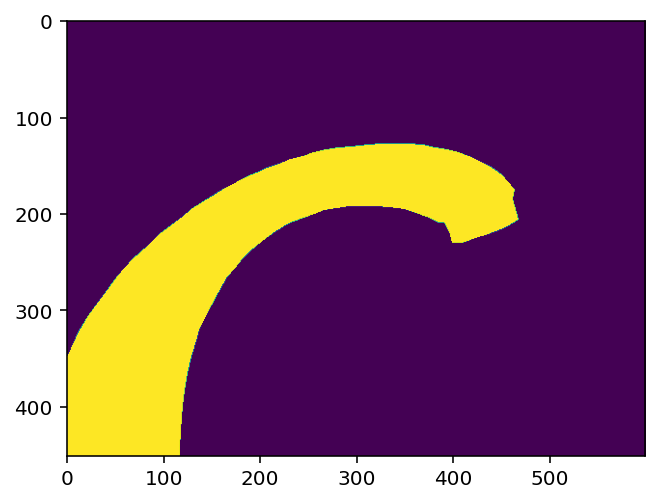

In [ ]:
original_mask = get_original_mask((h, w), coco_json['annotations'][72])
plt.imshow(original_mask)

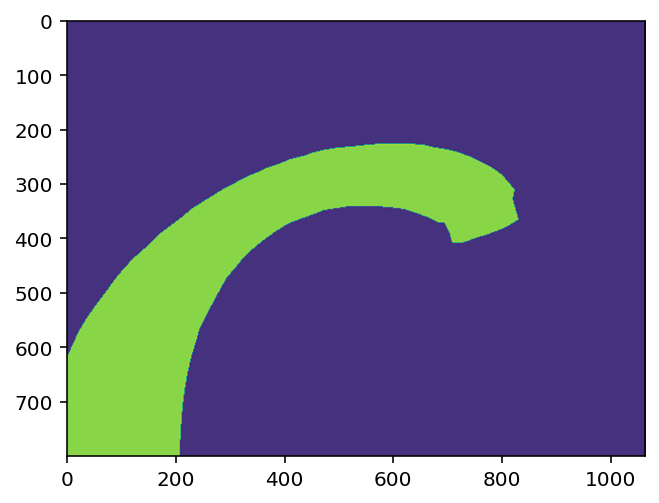

In [ ]:
original_mask = cv2.resize(original_mask, dsize=(panoptic_seg.shape[1], panoptic_seg.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(original_mask)

In [ ]:
panoptic_seg_id[original_mask.astype(np.bool_)] = panoptic_seg_id.max() + 1

In [ ]:
image_id = 72

image_info = {
    "id": image_id,
    "file_name": "",
    "width": w,
    "height": h,
    "date_captured": "",
    "license": "",
}

In [ ]:
coco_output["images"].append(image_info)

In [26]:
def resize_binary_mask(array, new_size):
    image = Image.fromarray(array.astype(np.uint8) * 255)
    image = image.resize(new_size)
    return np.asarray(image).astype(np.bool_)

In [27]:
def binary_mask_to_rle(binary_mask):
    rle = {"counts": [], "size": list(binary_mask.shape)}
    counts = rle.get("counts")
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order="F"))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))

    return rle

In [28]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

In [29]:
def binary_mask_to_polygon(binary_mask, tolerance=0):
    """Converts a binary mask to COCO polygon representation

    Args:
        binary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.

    """
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(
        binary_mask, pad_width=1, mode="constant", constant_values=0
    )
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

In [30]:
def create_annotation_info(
    annotation_id,
    image_id,
    category_info,
    binary_mask,
    image_size=None,
    tolerance=2,
    bounding_box=None,
):

    if image_size is not None:
        binary_mask = resize_binary_mask(binary_mask, image_size)

    binary_mask_encoded = mask.encode(np.asfortranarray(binary_mask.astype(np.uint8)))

    area = mask.area(binary_mask_encoded)
    if area < 1:
        return None

    if bounding_box is None:
        bounding_box = mask.toBbox(binary_mask_encoded)

    if category_info["is_crowd"]:
        is_crowd = 1
        segmentation = binary_mask_to_rle(binary_mask)
    else:
        is_crowd = 0
        segmentation = binary_mask_to_polygon(binary_mask, tolerance)
        if not segmentation:
            return None

    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_info["id"],
        "iscrowd": is_crowd,
        "area": area.tolist(),
        "bbox": bounding_box.tolist(),
        "segmentation": segmentation,
        "width": binary_mask.shape[1],
        "height": binary_mask.shape[0],
    }

    return annotation_info


In [31]:
def convert_to_coco(binary_mask, image_size, image_id, class_id, segmentation_id, iscrowd):
    category_info = {"id": class_id, "is_crowd": iscrowd}
    annotation_info = create_annotation_info(
        segmentation_id, image_id, category_info, binary_mask, image_size, tolerance=2)

    return annotation_info

In [32]:
import datetime
def create_image_info(
    image_id,
    file_name,
    image_size,
    date_captured=datetime.datetime.utcnow().isoformat(" "),
    license_id=1,
    coco_url="",
    flickr_url="",
):

    image_info = {
        "id": image_id,
        "file_name": file_name,
        "width": image_size[0],
        "height": image_size[1],
        "date_captured": date_captured,
        "license": license_id,
    }

    return image_info

In [33]:
from pycocotools import mask
from skimage import measure

for id in np.unique(panoptic_seg_id)[:-1]:  # Skip the last one as it is for custom mappings
    binary_masks[id, :, :] = panoptic_seg_id == id
    annotation_info = convert_to_coco(
        binary_masks[id],
        None,
        image_id,
        result["segments_info"][id]["category_id"],
        result["segments_info"][id]["id"],
        False,
    )
    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [ ]:
with open("{}/instances_custom.json".format(ROOT_DIR), "w") as output_json_file:
    json.dump(coco_output, output_json_file)

## Looped

In [34]:
# since we are treating all things as misc and that belongs to single color class, we can use colors of other things
AVAILABLE_COLORS = [
    [119, 11, 32],
    [0, 0, 142],
    [0, 0, 230],
    [106, 0, 228],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 70],
    [0, 0, 192],
    [250, 170, 30],
    [100, 170, 30],
    [220, 220, 0],
    [175, 116, 175],
    [250, 0, 30],
    [165, 42, 42],
    [255, 77, 255],
    [0, 226, 252],
    [182, 182, 255],
    [0, 82, 0],
    [120, 166, 157],
    [110, 76, 0],
    [174, 57, 255],
    [199, 100, 0],
    [72, 0, 118],
    [255, 179, 240],
    [0, 125, 92],
    [209, 0, 151],
    [188, 208, 182],
    [0, 220, 176],
    [255, 99, 164],
    [92, 0, 73],
    [133, 129, 255],
    [78, 180, 255],
    [0, 228, 0],
    [174, 255, 243],
    [45, 89, 255],
    [134, 134, 103],
    [145, 148, 174],
    [255, 208, 186],
    [197, 226, 255],
    [171, 134, 1],
    [109, 63, 54],
    [207, 138, 255],
    [151, 0, 95],
    [9, 80, 61],
    [84, 105, 51],
    [74, 65, 105],
    [166, 196, 102],
    [208, 195, 210],
    [255, 109, 65],
    [0, 143, 149],
    [179, 0, 194],
    [209, 99, 106],
    [5, 121, 0],
    [227, 255, 205],
]

In [35]:
CUSTOM_CATEGORIES_NAMES = [
    "aac_blocks",
    "adhesives",
    "ahus",
    "aluminium_frames_for_false_ceiling",
    "chiller",
    "concrete_mixer_machine",
    "concrete_pump",
    "control_panel",
    "cu_piping",
    "distribution_transformer",
    "dump_truck_tipper_truck",
    "emulsion_paint",
    "enamel_paint",
    "fine_aggregate",
    "fire_buckets",
    "fire_extinguishers",
    "glass_wool",
    "grader",
    "hoist",
    "hollow_concrete_blocks",
    "hot_mix_plant",
    "hydra_crane",
    "interlocked_switched_socket",
    "junction_box",
    "lime",
    "marble",
    "metal_primer",
    "pipe_fittings",
    "rcc_hume_pipes",
    "refrigerant_gas",
    "river_sand",
    "rmc_batching_plant",
    "rmu_units",
    "sanitary_fixtures",
    "skid_steer_loader",
    "smoke_detectors",
    "split_units",
    "structural_steel_channel",
    "switch_boards_and_switches",
    "texture_paint",
    "threaded_rod",
    "transit_mixer",
    "vcb_panel",
    "vitrified_tiles",
    "vrf_units",
    "water_tank",
    "wheel_loader",
    "wood_primer",
]



In [36]:
NEW_CATEGORIES = [
    {"color": [220, 20, 60], "isthing": 0, "id": 1, "name": "misc"},
    {"color": [255, 255, 128], "isthing": 0, "id": 2, "name": "textile"},
    {"color": [150, 100, 100], "isthing": 0, "id": 3, "name": "building"},
    {"color": [168, 171, 172], "isthing": 0, "id": 4, "name": "rawmaterial"},
    {"color": [146, 112, 198], "isthing": 0, "id": 5, "name": "furniture"},
    {"color": [218, 88, 184], "isthing": 0, "id": 6, "name": "floor"},
    {"color": [241, 129, 0], "isthing": 0, "id": 7, "name": "plant"},
    {"color": [217, 17, 255], "isthing": 0, "id": 8, "name": "food"},
    {"color": [124, 74, 181], "isthing": 0, "id": 9, "name": "ground"},
    {"color": [193, 0, 92], "isthing": 0, "id": 10, "name": "structural"},
    {"color": [60, 143, 255], "isthing": 0, "id": 11, "name": "water"},
    {"color": [137, 54, 74], "isthing": 0, "id": 12, "name": "wall"},
    {"color": [183, 121, 142], "isthing": 0, "id": 13, "name": "window"},
    {"color": [146, 139, 141], "isthing": 0, "id": 14, "name": "ceiling"},
    {"color": [70, 130, 180], "isthing": 0, "id": 15, "name": "sky"},
    {"color": [64, 170, 64], "isthing": 0, "id": 16, "name": "solid"},
]

In [37]:
category_id = 17
available_color_id = 0
for category in CUSTOM_CATEGORIES_NAMES:
    NEW_CATEGORIES.append(
        {
            "color": AVAILABLE_COLORS[available_color_id],
            "isthing": 1,
            "id": category_id,
            "name": category,
        }
    )
    category_id += 1
    available_color_id += 1

cat2id = {category["name"]: category["id"] for category in NEW_CATEGORIES}

id2cat = {i: name for name, i in cat2id.items()}

In [46]:
ROOT_DIR = '/content/drive/MyDrive/EVA6/Capstone/dataset'

processing_file = ""
processing_data = []

image_id = 1
annotation_id = 1
segment_id = 1

GLOBAL_COCO = {
    "licenses": LICENSES,
    "info": INFO,
    "categories": NEW_CATEGORIES,
    "annotations": [],
    "images": []
}

GLOBAL_PANOPTIC = {
    "licenses": LICENSES,
    "info": INFO,
    "categories": NEW_CATEGORIES,
    "annotations": [],
    "images": []
}

In [39]:
MAPPINGS = {
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 1,
    13: 1,
    14: 1,
    15: 1,
    16: 1,
    17: 1,
    18: 1,
    19: 1,
    20: 1,
    21: 1,
    22: 1,
    23: 1,
    24: 1,
    25: 1,
    27: 1,
    28: 1,
    31: 1,
    32: 1,
    33: 1,
    34: 1,
    35: 1,
    36: 1,
    37: 1,
    38: 1,
    39: 1,
    40: 1,
    41: 1,
    42: 1,
    43: 1,
    44: 1,
    46: 1,
    47: 1,
    48: 1,
    49: 1,
    50: 1,
    51: 1,
    52: 1,
    53: 1,
    54: 1,
    55: 1,
    56: 1,
    57: 1,
    58: 1,
    59: 1,
    60: 1,
    61: 1,
    62: 1,
    63: 1,
    64: 1,
    65: 1,
    67: 1,
    70: 1,
    72: 1,
    73: 1,
    74: 1,
    75: 1,
    76: 1,
    77: 1,
    78: 1,
    79: 1,
    80: 1,
    81: 1,
    82: 1,
    84: 1,
    85: 1,
    86: 1,
    87: 1,
    88: 1,
    89: 1,
    90: 1,
    92: 2,
    93: 2,
    95: 3,
    100: 4,
    107: 5,
    109: 2,
    112: 5,
    118: 6,
    119: 7,
    122: 8,
    125: 9,
    128: 3,
    130: 5,
    133: 5,
    138: 10,
    141: 2,
    144: 9,
    145: 9,
    147: 9,
    148: 11,
    149: 9,
    151: 3,
    154: 9,
    155: 11,
    156: 5,
    159: 9,
    161: 5,
    166: 3,
    168: 2,
    171: 12,
    175: 12,
    176: 12,
    177: 12,
    178: 11,
    180: 13,
    181: 13,
    184: 7,
    185: 10,
    186: 14,
    187: 15,
    188: 5,
    189: 5,
    190: 6,
    191: 9,
    192: 16,
    193: 7,
    194: 9,
    195: 4,
    196: 8,
    197: 3,
    198: 16,
    199: 12,
    200: 2,
}

In [40]:
import glob

# category_paths = glob.glob('./dataset/*')
category_paths = glob.glob('/content/drive/MyDrive/EVA6/Capstone/dataset/*')


In [47]:
category_paths = [
      '/content/drive/MyDrive/EVA6/Capstone/dataset/aac_blocks'
]
category_paths

['/content/drive/MyDrive/EVA6/Capstone/dataset/aac_blocks']

In [ ]:
# !mkdir /content/drive/MyDrive/EVA/dataset/images
# !mkdir /content/drive/MyDrive/EVA/dataset/masks

In [52]:
import time
import os
import json
from skimage import measure
import traceback

############################ Create DATASET ################################

# run through all folders in dataset
for category_path in category_paths:
    # store starting time
    start = time.time()
    # get category name
    category_name = category_path.split("/")[7]

    print("Processing Category:", category_name)
    # open category coco file
    with open(os.path.join(category_path, "coco.json"), "r") as coco_file:
        category_coco = json.load(coco_file)
        
    images_root = os.path.join(category_path, 'images')


    # Process all images
    ## 1. Create a temp json which contains each image and its annotations
    ## 2. Run over this list
    ### 1. Copy this image as .jpg in GLOBAL_DIR
    ### 2. Find all segments for this image
    ### 3. Create new anotation segment which includes annotations from custom classes
    
    TEMP_COCO_IMAGES = {}
    
    # Run over all images
    for im in category_coco["images"]:
        im['annotations'] = []
        TEMP_COCO_IMAGES[im['id']] = im
        
    for ann in category_coco["annotations"]:
        TEMP_COCO_IMAGES[ann['image_id']]["annotations"].append(ann)
        
    for i, image_coco in TEMP_COCO_IMAGES.items():
        # get image path
        ## This data can be used further for logging if failed while processing
        processing_file = os.path.join(images_root, image_coco['file_name'])
        processing_data = image_coco
        output_file_name = category_name + "_" + str(image_id) + ".jpg"
        output_file_path = os.path.join(ROOT_DIR, "images", output_file_name)
        
        output_mask_name = category_name + "_" + str(image_id) + ".png"
        output_mask_path = os.path.join(ROOT_DIR, "masks", output_mask_name)  

        try:

          # Read this image and get shape of image
          imo = Image.open(processing_file).convert('RGB')

          try:
              h, w, c = np.array(imo).shape
          except:
              h, w = np.array(imo).shape
              c = 1

          # if no of channels != 3, open the image and convert it to 3 channel - RGB
          if c == 4 or c == 1:
              imo = imo.convert('RGB')
              h, w, c = np.array(imo).shape

          # Create a copy of image this will be used for further processing
          im = imo.copy()

          # Apply transform and convert image to batch
          # mean-std normalize the input image (batch-size: 1)
          img = transform(im).unsqueeze(0).to(device)  # [h, w, c] -> [1, c, ht, wt]

          # Generate output for image
          out = model(img)

          # Generate score
          # compute the scores, excluding the "no-object" class (the last one)
          scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]

          # threshold the confidence
          keep = scores > 0.85

          # Keep only ones above threshold
          pred_logits, pred_boxes = out["pred_logits"][keep][:, :len(COCO_NAMES) - 1], out["pred_boxes"][keep]

          # the post-processor expects as input the target size of the predictions (which we set here to the image size)
          result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

          # The segmentation is stored in a special-format png
          panoptic_seg = Image.open(io.BytesIO(result['png_string'])).resize((w, h), Image.NEAREST)
          # (wp, hp) = panoptic_seg.size
          panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()

          # We retrieve the ids corresponding to each mask
          panoptic_seg_id = rgb2id(panoptic_seg)
          
          ## Merge predicted annotations
          
          # 1. Get Mapping from predicted id to new ids
          ## 1. Merge segment ids
          unique_category_id = []
          for i, segment in enumerate(result['segments_info']):
              result['segments_info'][i]["category_id"] = MAPPINGS[result['segments_info'][i]["category_id"]]
              if result['segments_info'][i]["category_id"] not in unique_category_id:
                  unique_category_id.append(result['segments_info'][i]["category_id"])
          
          # Sort array
          unique_category_id.sort()
          
          unique_category_id_to_id =  {category_id: i for i, category_id in enumerate(unique_category_id)}
          unique_id_to_category_id =  {i: category_id for category_id, i in unique_category_id_to_id.items()}
          
          for i, segment in enumerate(result['segments_info']):
              result['segments_info'][i]["new_id"] = unique_category_id_to_id[result['segments_info'][i]["category_id"]]
          
          # Update original panoptic_seg_id array with new ids as the new segmentation combines different categories.
          custom_panoptic_seg_id = np.zeros((panoptic_seg_id.shape[0], panoptic_seg_id.shape[1]), dtype=np.uint8)
          
          # Update this custom panoptic seg matrix
          for i, segment in enumerate(result['segments_info']):
              custom_panoptic_seg_id[result['segments_info'][i]['id'] == panoptic_seg_id] = result['segments_info'][i]['new_id']
              
          # Create new Segmentation info
          # [{'area': 243, 'category_id': 3, 'id': 0, 'isthing': True},
          #   {'area': 730578, 'category_id': 184, 'id': 1, 'isthing': False}]
          
          custom_panoptic_segments_info = []
          for category_id in unique_category_id:
              custom_panoptic_segments_info.append({
                  'segment_id': unique_category_id_to_id[category_id], 
                  'category_id': category_id,
                  'bbox': [],
                  'area': 0,
                  'iscroud': 0,
                  'isthing': 0
              })

          # annotations of our construction things
          omask = processing_data['annotations']
          
          TEMP_ANNOTATIONS = []
          
          # Overlay things mask one at a time
          for annotation in omask:
              # overlay mask of construction things on top of detr output
              omask_image_id = get_original_mask((h, w), annotation)
              omask_image_id = cv2.resize(omask_image_id, dsize=(panoptic_seg.shape[1], panoptic_seg.shape[0]), 
                                          interpolation=cv2.INTER_CUBIC)
              custom_panoptic_seg_id[omask_image_id.astype(np.bool_)] = custom_panoptic_seg_id.max() + 1
              custom_panoptic_segments_info.append({
                  'segment_id': custom_panoptic_seg_id.max(), 
                  'category_id': cat2id[category_name], 
                  'bbox': annotation['bbox'],
                  'area': annotation['area'],
                  'iscroud': 0,
                  'isthing': 1
              })

              # append annotation of construction things in json file
              annotation["category_id"] = cat2id[category_name]
              annotation["image_id"] = image_id
              TEMP_ANNOTATIONS.append(annotation)
          
          # Convert to binary segment
          binary_masks = np.zeros((
              custom_panoptic_seg_id.max() + 1,
              custom_panoptic_seg_id.shape[0],
              custom_panoptic_seg_id.shape[1]),
              dtype=np.uint8
          )
              
          # for each binary mask, detect contours and create annotation for those contours
          if len(unique_category_id):
              # Skip the onse which are added by us
              for category_id in unique_category_id:
                  binary_masks[unique_category_id_to_id[category_id], :, :] = custom_panoptic_seg_id == unique_category_id_to_id[category_id]
                  annotation_info = convert_to_coco(binary_masks[unique_category_id_to_id[category_id]], None, image_id, category_id, unique_category_id_to_id[category_id], 0)
                  if annotation_info is not None:
                      annotation_info["image_id"] = image_id
                      annotation_info["category_id"] = category_id
                      TEMP_ANNOTATIONS.append(annotation_info)
                      
                      custom_panoptic_segments_info[unique_category_id_to_id[category_id]]['bbox'] = annotation_info['bbox']
                      custom_panoptic_segments_info[unique_category_id_to_id[category_id]]['area'] = annotation_info['area']
          else:
              # Do something for the once where there are no predictions
              ## Probably mark them as None
              pass
          
          

          # Write data to global json and save files to image dir's
          
          # save image to new path as .jpg
          imo.save(output_file_path)
          
          # save panoptic image
          Image.fromarray(id2rgb(custom_panoptic_seg_id), 'RGB').save(output_mask_path)

          # create image_info object and append it to original list
          image_info = create_image_info(image_id, output_file_name, imo.size)
          image_info["original_file"] = processing_file

          GLOBAL_COCO["images"].append(image_info)
          GLOBAL_PANOPTIC["images"].append(image_info)

          for annotation in TEMP_ANNOTATIONS:
              annotation["id"] = annotation_id
              GLOBAL_COCO["annotations"].append(annotation)
              annotation_id += 1
              
          for segment_info in custom_panoptic_segments_info:
              segment_info["id"] = segment_id
              segment_id += 1
              
          GLOBAL_PANOPTIC["annotations"].append({
              "segments_info": custom_panoptic_segments_info,
              "file_name": output_mask_name,
              "image_id": image_id
          })

          # increment the image_count
          image_id += 1
        
        except Exception as e:
            # if there is any error, add info about it in errros file and procees to next image
            print("Error occurred while processig file:", processing_file)
            
            with open(os.path.join(ROOT_DIR, "error.json"), 'r') as error_file:
                error_json = json.load(error_file)
                
            with open(os.path.join(ROOT_DIR, "error.json"), 'w') as error_file:
                error_json["error"].append({
                    "processing_file": processing_file,
                    "processing_data": processing_data
                })
                
                json.dump(error_json, error_file)
                
            traceback.print_exc()

    total_time_str = str(datetime.timedelta(seconds=int(time.time() - start)))
    print(f"Completed Category: {category_name}, Time Taken: {total_time_str}")

    # open the final json, and commit changes in that file
    with open(os.path.join(ROOT_DIR, "coco.json"), 'w') as output_json_file:
        json.dump(GLOBAL_COCO, output_json_file)
        
    with open(os.path.join(ROOT_DIR, "panoptic.json"), 'w') as output_json_file:
        json.dump(GLOBAL_PANOPTIC, output_json_file, default=convert)
        
    print(image_id, annotation_id, segment_id)


Processing Category: aac_blocks


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Completed Category: aac_blocks, Time Taken: 0:03:31
264 1037 1038


In [44]:
def convert(o):
    if isinstance(o, np.generic): return o.item()  
    raise TypeError



In [55]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.3 GB
Cached:    0.4 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [54]:
torch.cuda.empty_cache()

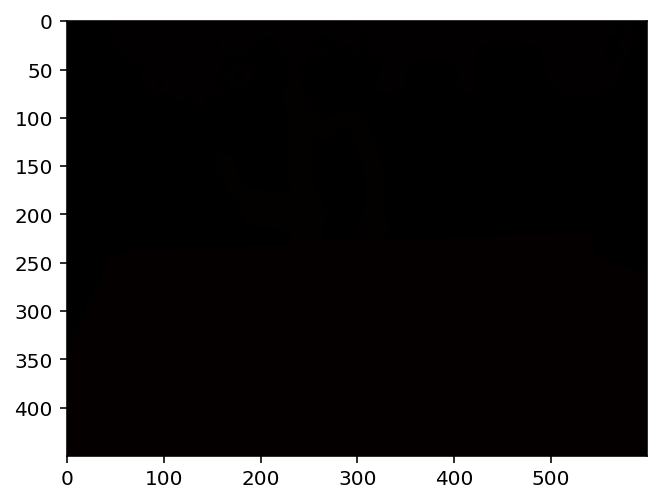

In [ ]:
# plt.imshow("/content/dataset/masks/sanitary_fixtures_100.png")

x = Image.open("/content/dataset/masks/sanitary_fixtures_100.png")
x = np.array(x, dtype=np.uint8).copy()
plt.imshow(x)

In [ ]:
result['segments_info']

[{'area': 381355, 'category_id': 189, 'id': 0, 'isthing': False},
 {'area': 146223, 'category_id': 119, 'id': 1, 'isthing': False},
 {'area': 323622, 'category_id': 199, 'id': 2, 'isthing': False}]

In [ ]:
!unzip "/content/drive/MyDrive/EVA/cap/construction_materials_dataset.zip" -d \
       "/content/drive/MyDrive/EVA/dataset"

In [51]:
!rm -rf /content/drive/MyDrive/EVA6/Capstone/dataset/coco.json
!rm -rf /content/drive/MyDrive/EVA6/Capstone/dataset/panoptic.json
!rm -rf /content/drive/MyDrive/EVA6/Capstone/dataset/error.json
!rm -rf /content/drive/MyDrive/EVA6/Capstone/dataset/images/*
!rm -rf /content/drive/MyDrive/EVA6/Capstone/dataset/masks/*

## Testings

In [ ]:
# ann_info = coco_json['annotations'][72] if "annotations" in coco_json else coco_json['images'][72]
# ann_info['segmentation'][0]

In [ ]:
# from matplotlib.patches import Polygon
# import numpy as np

# polygons = []
# poly = np.array(ann_info['segmentation'][0]).reshape((int(len(ann_info['segmentation'][0])/2), 2))
# polygons.append(Polygon(poly))


In [ ]:
# polygons[0].get_xy()

In [ ]:
# import cv2

# contours = polygons[0].get_xy().astype(np.int32)
# contours

In [ ]:
# res = cv2.resize(panoptic_seg, dsize=(w, h), interpolation=cv2.INTER_CUBIC)

In [ ]:
# panoptic_seg.shape, res.shape

In [ ]:
# next_color = numpy.asarray(next(palette)) * 255
# next_color

In [ ]:
# cv2.fillPoly(res, pts = [contours], color = next_color)
# cv2_imshow(res)

In [ ]:
plt.imsave("sample.png",res)

In [ ]:
from pycocotools.coco import COCO
from pycocotools import mask

In [ ]:
es = np.asarray(res, order='F')

In [ ]:
# x = mask.encode(es)
# x

[{'counts': b'041e10]40_LW3^MiLNh10]40kIa2Y3aMgLg10\\40kI_2[3cMeLg10]40WL]3eMcLg10^40iI0W2`3kM`Lf10XNX60hI010P2b3RN^Le10c4R2YMRNTNL_40iI0Q2f3RN[LMOe10c40hIo1h3UNXLL00c10]NX60hIl1k3ZNUL^10f40`Km3\\NSL^10e40gIh1o3^NQLJb10^NX60hIg1Q4_NoK]10d40iI0f1S4`NmK]10]NU60kIg1T4_NlK^10b40_KV4aNjKJb10^NQ60oI020`1X4eNhK[10^NP60PJ000010O_1Y4hNgKIb10]40QJ10O020N\\1[4lNeKZ10[40SJ01004OV1]4nNcKH`10\\40TJ3050P1^4QObKG]10cN0l50WJ0M80n0`4TO`KF80j00nNm50WJ0L70n0a4@_K[O1010h00S50XJ0K70l0c4J]KSOi00U50VJ040j0d4L\\KRO007060a50RJ20N9Q1\\40[KoN020O0O56Kh50RJ208010F0O=g4f0YKmN00000060J030l50QJ000;9EG010O<h4X1XK^N0NP60PJ0<0L0M04j4\\1VK[N00o50TJ0M08010G306k4]1UKZNP66PJN0L00090G20N8l4a7`KWHD00<2D5n4a7RK`Io4^6QKZHX1P5]6PKbI0k3e7UL[Hl3d7mJbI0n3a7lJgIV5Y6jJ_HV1W5[6iJ_HU1X5\\6hJ_H`00@20N;Z5W7fJjH2DN030M9[5Y7eJiH010J\\5\\7dJ^H90G=0F^5a7bJdH0H=0C1_5d7aJ[H0609a5Y7_J]H09b5[7cJWH8c5\\7]JWH020N:e5`7[JVH0000008f5f7ZJTH7e5h7YJQH05i5k7XJTHi5R81O1O1N2O1O1O1O1O1O1O1N2O1O1O1O1O1O1O100O1O1O1O1O1O1O100O1O1O1O1O1O1O1O1O1O1O1O1O1O1O1O1PMj

In [ ]:
# area = mask.area(x)
# area

array([139159, 133434, 137905], dtype=uint32)

In [ ]:
# box = mask.toBbox(x)
# box

array([[  0.,   0., 600., 451.],
       [  0.,   0., 600., 451.],
       [  0.,   0., 600., 451.]])

## Panoptic visualization using Detectron2

In this section we demonstrate how to obtain a better looking visualization by leveraging Detectron2's plotting utilities.

In [ ]:
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

Finally, we visualize it

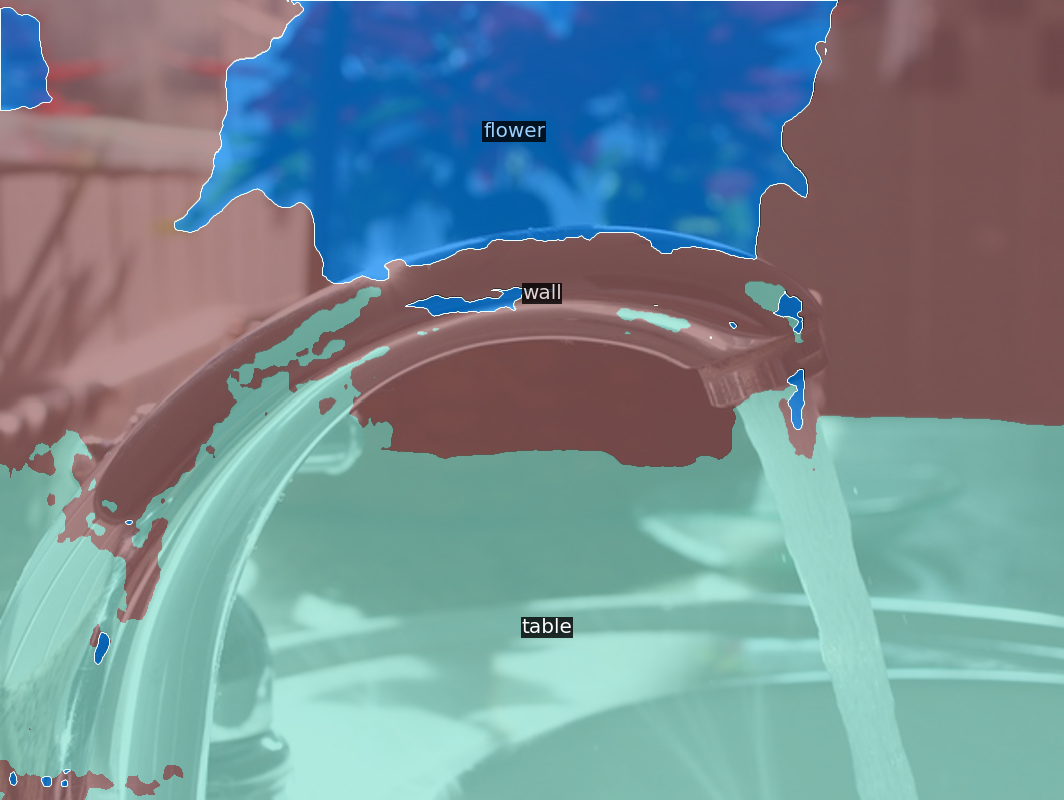

In [ ]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

In [ ]:
meta

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='datasets/coco/val2017', json_file='datasets/coco/annotations/instances_val2017.json', name='coco_2017_val_panoptic_separated', panoptic_json='datasets/coco/annotations/panoptic_val2017.json', panoptic_root='datasets/coco/panoptic_val2017', sem_seg_root='datasets/coco/panoptic_stuff_val2017', stuff_classes=['things', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water', 'window-blind', 'window', 'tree', 'fence', 'ceiling', 'sky', 'cabinet', 'table', 'floor', 'pavement', 'mountain', 'grass', 'dirt', 'paper', 'food', 'building', 'rock', 'wall', 'rug'], stuff_colors=[[82, 18, 128], [255, 255, 128], [147, 211, 203],